# Importando módulos 

In [193]:
import obspy
from obspy.taup import TauPyModel

from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
import glidertools as gt


#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [174]:
FOLDER_OUTPUT = '/home/dIOGOLOC/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

NetCDF_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/NetCDF_data/"

START_DATE_EV = "2018-07-01"

FINAL_DATE_EV = "2018-12-31"

MIN_MAG_EV = 6

# Extraindo informações dos arquivos ".mseed"

In [181]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [182]:
pandas_mseed_lst = []
for i in tqdm(filenames_MSEED):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    #----------------------------
    #Starting Dataframe

    starttime = d.datetime
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime]], index=['filename', 'mergulho', 'stream_number','starttime']).T
    
    #Ending Dataframe
    #----------------------------
    pandas_mseed_lst.append(df) 

  6%|██▏                                | 6879/109315 [00:04<01:08, 1484.76it/s]


KeyboardInterrupt: 

In [119]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)


In [183]:
dataframe_mseed_final

,filename,mergulho,stream_number,starttime,diff
0,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,1262 days 20:36:45
1,pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,1262 days 20:34:45
2,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,1262 days 20:32:45
3,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,1262 days 20:30:45
4,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,1262 days 20:28:45
...,...,...,...,...,...
109310,pa0238au_013_191010_211037,0238,013,2019-10-10 21:10:37,165 days 10:45:11
109311,pa0238au_014_191010_212037,0238,014,2019-10-10 21:20:37,165 days 10:55:11
109312,pa0238au_015_191010_213037,0238,015,2019-10-10 21:30:37,165 days 11:05:11
109313,pa0238au_016_191010_214037,0238,016,2019-10-10 21:40:37,165 days 11:15:11


In [128]:
# Calcule a diferença absoluta entre as datas e o valor de referência
dataframe_mseed_final['diff'] = np.abs(dataframe_mseed_final['starttime'].dt.to_pydatetime() - event.datetime)

# Obtenha o índice da linha com a menor diferença
index_next = dataframe_mseed_final['diff'].idxmin()

# Obtenha a data mais próxima
file_event_mseed = dataframe_mseed_final.loc[index_next, 'filename']

In [135]:
file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/'+file_event_mseed+'*'))[0]

In [136]:
ev_file = read(file_mseed_ev)

/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


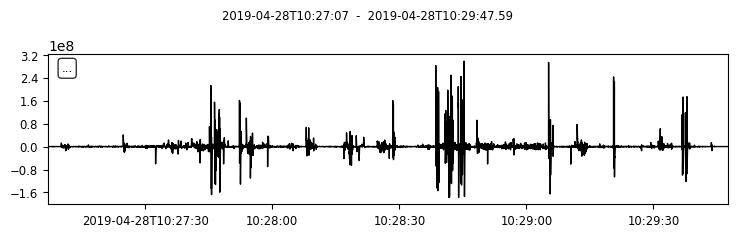

/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


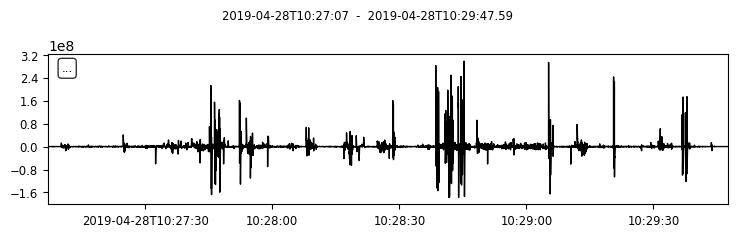

In [137]:
ev_file.trim(starttime=None,endtime=None)

# Extraindo informações dos arquivos ".nc"

In [176]:
filenames_nc = sorted(glob.glob(NetCDF_INPUT+'*/*.nc'))

In [178]:
names = [
    'time',
    'dives',
    'latitude',
    'longitude',
    'depth']

pandas_lst = []
for file in tqdm(filenames_nc):
    glider_dic = {'file_location':[],'dive':[],"lat":[],'lon':[],"geospatial_vertical_max":[],"time_coverage_start":[],"time_coverage_end":[],"timelapse":[]}

    dic_ds = gt.load.seaglider_basestation_netCDFs(file, names,verbose=False)
    glider_dic['file_location'].append(file)
    glider_dic['dive'].append(dic_ds['sg_data_point'].attrs['number_of_dives'])
    glider_dic['lat'].append(dic_ds['sg_data_point'].attrs['geospatial_lat_min'])
    glider_dic['lon'].append(dic_ds['sg_data_point'].attrs['geospatial_lon_min'])
    glider_dic['geospatial_vertical_max'].append(dic_ds['sg_data_point'].attrs['geospatial_vertical_max']*-1)
    glider_dic['time_coverage_start'].append(mdates.date2num(obspy.UTCDateTime(dic_ds['sg_data_point'].attrs['time_coverage_start'])))
    glider_dic['time_coverage_end'].append(mdates.date2num(obspy.UTCDateTime(dic_ds['sg_data_point'].attrs['time_coverage_end'])))
    glider_dic['timelapse'].append(obspy.UTCDateTime(dic_ds['sg_data_point'].attrs['time_coverage_end'])-obspy.UTCDateTime(dic_ds['sg_data_point'].attrs['time_coverage_start']))
    
 
    if dic_ds['sg_data_point'].attrs['geospatial_lat_min'] != []:
        df = pd.DataFrame.from_dict(glider_dic)
    pandas_lst.append(df)  

  0%|                                                  | 0/1467 [00:00<?, ?it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|                                          | 1/1467 [00:00<12:45,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|                                          | 2/1467 [00:01<13:06,  1.86it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|                                          | 3/1467 [00:01<12:20,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|                                          | 4/1467 [00:01<11:46,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|▏                                         | 5/1467 [00:02<11:31,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|▏                                         | 6/1467 [00:02<11:22,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  0%|▏                                         | 7/1467 [00:03<11:22,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▏                                         | 8/1467 [00:03<11:13,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▎                                         | 9/1467 [00:04<11:06,  2.19it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▎                                        | 10/1467 [00:04<11:16,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▎                                        | 11/1467 [00:05<11:16,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▎                                        | 12/1467 [00:05<11:17,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▎                                        | 13/1467 [00:06<11:25,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▍                                        | 14/1467 [00:07<20:10,  1.20it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▍                                        | 15/1467 [00:08<17:17,  1.40it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▍                                        | 16/1467 [00:08<15:43,  1.54it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▍                                        | 17/1467 [00:09<14:31,  1.66it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▌                                        | 18/1467 [00:09<13:37,  1.77it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▌                                        | 19/1467 [00:10<12:52,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▌                                        | 20/1467 [00:10<12:35,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▌                                        | 21/1467 [00:11<12:12,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  1%|▌                                        | 22/1467 [00:11<11:51,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▋                                        | 23/1467 [00:12<11:37,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▋                                        | 24/1467 [00:12<11:25,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▋                                        | 25/1467 [00:13<11:23,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▋                                        | 26/1467 [00:13<11:20,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▊                                        | 27/1467 [00:13<11:37,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▊                                        | 28/1467 [00:14<11:38,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▊                                        | 29/1467 [00:14<11:28,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▊                                        | 30/1467 [00:15<11:35,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▊                                        | 31/1467 [00:15<11:42,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▉                                        | 32/1467 [00:16<11:50,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▉                                        | 33/1467 [00:16<11:48,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▉                                        | 34/1467 [00:17<11:55,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|▉                                        | 35/1467 [00:17<12:02,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  2%|█                                        | 36/1467 [00:18<11:59,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█                                        | 37/1467 [00:19<12:29,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█                                        | 38/1467 [00:19<12:32,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█                                        | 39/1467 [00:20<12:47,  1.86it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█                                        | 40/1467 [00:20<12:35,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▏                                       | 41/1467 [00:21<13:04,  1.82it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▏                                       | 42/1467 [00:21<13:09,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▏                                       | 43/1467 [00:22<13:21,  1.78it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▏                                       | 44/1467 [00:22<13:18,  1.78it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▎                                       | 45/1467 [00:23<12:54,  1.84it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▎                                       | 46/1467 [00:23<12:29,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▎                                       | 47/1467 [00:24<12:26,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▎                                       | 48/1467 [00:24<12:05,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▎                                       | 49/1467 [00:25<11:49,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▍                                       | 50/1467 [00:26<12:42,  1.86it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  3%|█▍                                       | 51/1467 [00:26<13:40,  1.73it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▍                                       | 52/1467 [00:27<13:47,  1.71it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▍                                       | 53/1467 [00:27<13:13,  1.78it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▌                                       | 54/1467 [00:28<12:39,  1.86it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▌                                       | 55/1467 [00:28<12:24,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▌                                       | 56/1467 [00:29<12:09,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▌                                       | 57/1467 [00:29<11:46,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▌                                       | 58/1467 [00:30<11:34,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▋                                       | 59/1467 [00:30<11:15,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▋                                       | 60/1467 [00:31<11:05,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▋                                       | 61/1467 [00:31<11:32,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▋                                       | 62/1467 [00:32<11:38,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▊                                       | 63/1467 [00:32<11:43,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▊                                       | 64/1467 [00:33<11:24,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▊                                       | 65/1467 [00:33<11:36,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  4%|█▊                                       | 66/1467 [00:34<11:32,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|█▊                                       | 67/1467 [00:34<11:34,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|█▉                                       | 68/1467 [00:35<11:30,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|█▉                                       | 69/1467 [00:35<11:26,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|█▉                                       | 70/1467 [00:36<11:27,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|█▉                                       | 71/1467 [00:36<11:30,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██                                       | 72/1467 [00:37<11:36,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██                                       | 73/1467 [00:37<11:33,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██                                       | 74/1467 [00:38<11:38,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██                                       | 75/1467 [00:38<11:48,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██                                       | 76/1467 [00:39<11:50,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██▏                                      | 77/1467 [00:39<11:43,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██▏                                      | 78/1467 [00:40<11:29,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██▏                                      | 79/1467 [00:40<11:54,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  5%|██▏                                      | 80/1467 [00:41<12:11,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▎                                      | 81/1467 [00:41<12:12,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▎                                      | 82/1467 [00:42<12:04,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▎                                      | 83/1467 [00:42<11:59,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▎                                      | 84/1467 [00:43<12:00,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▍                                      | 85/1467 [00:43<12:08,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▍                                      | 86/1467 [00:44<12:24,  1.85it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▍                                      | 87/1467 [00:44<12:17,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▍                                      | 88/1467 [00:45<12:13,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▍                                      | 89/1467 [00:46<11:57,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▌                                      | 90/1467 [00:46<11:40,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▌                                      | 91/1467 [00:46<11:32,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▌                                      | 92/1467 [00:47<11:27,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▌                                      | 93/1467 [00:47<11:16,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▋                                      | 94/1467 [00:48<11:17,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  6%|██▋                                      | 95/1467 [00:48<11:25,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▋                                      | 96/1467 [00:49<11:32,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▋                                      | 97/1467 [00:50<11:47,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▋                                      | 98/1467 [00:50<12:13,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▊                                      | 99/1467 [00:51<12:16,  1.86it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▋                                     | 100/1467 [00:51<12:00,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▊                                     | 101/1467 [00:52<12:08,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▊                                     | 102/1467 [00:52<12:51,  1.77it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▊                                     | 103/1467 [00:53<12:44,  1.78it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▊                                     | 104/1467 [00:53<12:03,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▊                                     | 105/1467 [00:54<12:02,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▉                                     | 106/1467 [00:54<12:03,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▉                                     | 107/1467 [00:55<12:17,  1.84it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▉                                     | 108/1467 [00:56<12:16,  1.85it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▉                                     | 109/1467 [00:56<12:53,  1.76it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  7%|██▉                                     | 110/1467 [00:57<12:51,  1.76it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███                                     | 111/1467 [00:57<12:54,  1.75it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███                                     | 112/1467 [00:58<13:05,  1.72it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███                                     | 113/1467 [00:59<13:21,  1.69it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███                                     | 114/1467 [00:59<13:19,  1.69it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▏                                    | 115/1467 [01:00<12:58,  1.74it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▏                                    | 116/1467 [01:00<12:44,  1.77it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▏                                    | 117/1467 [01:01<12:31,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▏                                    | 118/1467 [01:01<12:25,  1.81it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▏                                    | 119/1467 [01:02<12:30,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▎                                    | 120/1467 [01:02<12:34,  1.79it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▎                                    | 121/1467 [01:03<12:29,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▎                                    | 122/1467 [01:04<12:32,  1.79it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▎                                    | 123/1467 [01:04<12:27,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  8%|███▍                                    | 124/1467 [01:05<12:18,  1.82it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▍                                    | 125/1467 [01:05<11:51,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▍                                    | 126/1467 [01:06<11:28,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▍                                    | 127/1467 [01:06<11:01,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▍                                    | 128/1467 [01:06<10:53,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▌                                    | 129/1467 [01:07<10:39,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▌                                    | 130/1467 [01:07<10:55,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▌                                    | 131/1467 [01:08<11:11,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▌                                    | 132/1467 [01:08<11:10,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▋                                    | 133/1467 [01:09<11:04,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▋                                    | 134/1467 [01:09<10:43,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▋                                    | 135/1467 [01:10<10:23,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▋                                    | 136/1467 [01:10<10:18,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▋                                    | 137/1467 [01:11<10:13,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▊                                    | 138/1467 [01:11<10:09,  2.18it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


  9%|███▊                                    | 139/1467 [01:12<10:01,  2.21it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▊                                    | 140/1467 [01:12<09:54,  2.23it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▊                                    | 141/1467 [01:13<09:54,  2.23it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▊                                    | 142/1467 [01:13<09:51,  2.24it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▉                                    | 143/1467 [01:13<09:46,  2.26it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▉                                    | 144/1467 [01:14<09:52,  2.23it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▉                                    | 145/1467 [01:14<09:55,  2.22it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|███▉                                    | 146/1467 [01:15<09:49,  2.24it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████                                    | 147/1467 [01:15<09:58,  2.21it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████                                    | 148/1467 [01:16<10:15,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████                                    | 149/1467 [01:18<19:13,  1.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████                                    | 150/1467 [01:18<16:27,  1.33it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████                                    | 151/1467 [01:18<14:32,  1.51it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████▏                                   | 152/1467 [01:19<13:16,  1.65it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████▏                                   | 153/1467 [01:19<12:36,  1.74it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 10%|████▏                                   | 154/1467 [01:20<12:05,  1.81it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▏                                   | 155/1467 [01:21<12:02,  1.82it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▎                                   | 156/1467 [01:21<11:36,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▎                                   | 157/1467 [01:22<11:29,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▎                                   | 158/1467 [01:22<11:27,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▎                                   | 159/1467 [01:23<11:17,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▎                                   | 160/1467 [01:23<11:06,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▍                                   | 161/1467 [01:24<10:57,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▍                                   | 162/1467 [01:24<10:51,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▍                                   | 163/1467 [01:24<10:49,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▍                                   | 164/1467 [01:25<11:12,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▍                                   | 165/1467 [01:26<11:50,  1.83it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▌                                   | 166/1467 [01:26<11:36,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▌                                   | 167/1467 [01:27<11:26,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 11%|████▌                                   | 168/1467 [01:27<11:19,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▌                                   | 169/1467 [01:28<11:10,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▋                                   | 170/1467 [01:28<10:50,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▋                                   | 171/1467 [01:29<10:33,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▋                                   | 172/1467 [01:29<10:25,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▋                                   | 173/1467 [01:30<10:23,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▋                                   | 174/1467 [01:30<10:19,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▊                                   | 175/1467 [01:31<10:27,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▊                                   | 176/1467 [01:31<10:42,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▊                                   | 177/1467 [01:32<10:22,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▊                                   | 178/1467 [01:32<10:34,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▉                                   | 179/1467 [01:32<10:20,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▉                                   | 180/1467 [01:33<10:03,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▉                                   | 181/1467 [01:33<10:14,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▉                                   | 182/1467 [01:34<10:35,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 12%|████▉                                   | 183/1467 [01:34<10:41,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████                                   | 184/1467 [01:35<10:28,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████                                   | 185/1467 [01:35<10:09,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████                                   | 186/1467 [01:36<09:56,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████                                   | 187/1467 [01:36<09:52,  2.16it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▏                                  | 188/1467 [01:37<09:38,  2.21it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▏                                  | 189/1467 [01:37<09:36,  2.22it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▏                                  | 190/1467 [01:38<09:40,  2.20it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▏                                  | 191/1467 [01:38<09:48,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▏                                  | 192/1467 [01:39<10:07,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▎                                  | 193/1467 [01:39<09:54,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▎                                  | 194/1467 [01:40<09:47,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▎                                  | 195/1467 [01:40<09:45,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▎                                  | 196/1467 [01:40<09:45,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▎                                  | 197/1467 [01:41<09:49,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 13%|█████▍                                  | 198/1467 [01:41<09:41,  2.18it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▍                                  | 199/1467 [01:42<09:36,  2.20it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▍                                  | 200/1467 [01:42<09:42,  2.18it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▍                                  | 201/1467 [01:43<10:11,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▌                                  | 202/1467 [01:43<09:58,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▌                                  | 203/1467 [01:44<09:45,  2.16it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▌                                  | 204/1467 [01:44<09:39,  2.18it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▌                                  | 205/1467 [01:45<09:51,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▌                                  | 206/1467 [01:45<09:47,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▋                                  | 207/1467 [01:46<09:53,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▋                                  | 208/1467 [01:46<09:57,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▋                                  | 209/1467 [01:47<10:25,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▋                                  | 210/1467 [01:47<10:29,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▊                                  | 211/1467 [01:48<10:15,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 14%|█████▊                                  | 212/1467 [01:48<10:15,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▊                                  | 213/1467 [01:49<10:22,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▊                                  | 214/1467 [01:49<10:26,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▊                                  | 215/1467 [01:50<10:08,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▉                                  | 216/1467 [01:50<09:51,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▉                                  | 217/1467 [01:50<09:41,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▉                                  | 218/1467 [01:51<09:48,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▉                                  | 219/1467 [01:51<09:52,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|█████▉                                  | 220/1467 [01:52<09:40,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████                                  | 221/1467 [01:52<09:34,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████                                  | 222/1467 [01:53<09:44,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████                                  | 223/1467 [01:53<09:52,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████                                  | 224/1467 [01:54<10:08,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████▏                                 | 225/1467 [01:54<10:13,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████▏                                 | 226/1467 [01:55<10:14,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 15%|██████▏                                 | 227/1467 [01:55<10:46,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▏                                 | 228/1467 [01:56<10:30,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▏                                 | 229/1467 [01:56<10:22,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▎                                 | 230/1467 [01:57<10:07,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▎                                 | 231/1467 [01:57<10:00,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▎                                 | 232/1467 [01:58<10:03,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▎                                 | 233/1467 [01:58<09:55,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▍                                 | 234/1467 [01:59<09:47,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▍                                 | 235/1467 [01:59<09:35,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▍                                 | 236/1467 [02:00<09:25,  2.18it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▍                                 | 237/1467 [02:00<09:19,  2.20it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▍                                 | 238/1467 [02:00<09:15,  2.21it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▌                                 | 239/1467 [02:01<09:21,  2.19it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▌                                 | 240/1467 [02:01<09:20,  2.19it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▌                                 | 241/1467 [02:02<09:29,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 16%|██████▌                                 | 242/1467 [02:02<09:34,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▋                                 | 243/1467 [02:03<09:28,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▋                                 | 244/1467 [02:03<09:33,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▋                                 | 245/1467 [02:04<09:44,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▋                                 | 246/1467 [02:04<10:13,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▋                                 | 247/1467 [02:05<10:29,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▊                                 | 248/1467 [02:05<10:48,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▊                                 | 249/1467 [02:06<10:29,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▊                                 | 250/1467 [02:06<10:20,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▊                                 | 251/1467 [02:07<10:34,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▊                                 | 252/1467 [02:08<10:35,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▉                                 | 253/1467 [02:08<10:30,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▉                                 | 254/1467 [02:09<10:25,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▉                                 | 255/1467 [02:09<10:21,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 17%|██████▉                                 | 256/1467 [02:10<10:16,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 18%|███████                                 | 257/1467 [02:10<09:56,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████                                 | 258/1467 [02:10<09:06,  2.21it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████                                 | 259/1467 [02:11<08:33,  2.35it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████                                 | 260/1467 [02:11<08:15,  2.43it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████                                 | 261/1467 [02:11<08:03,  2.49it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▏                                | 262/1467 [02:12<07:59,  2.51it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▏                                | 263/1467 [02:12<07:48,  2.57it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▏                                | 264/1467 [02:13<07:57,  2.52it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▏                                | 265/1467 [02:13<07:45,  2.58it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▎                                | 266/1467 [02:13<07:33,  2.65it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▎                                | 267/1467 [02:14<07:35,  2.64it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▎                                | 268/1467 [02:14<07:40,  2.60it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: latitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: longitude was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth}


 18%|███████▎                                | 269/1467 [02:15<07:41,  2.60it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 18%|███████▎                                | 270/1467 [02:15<08:42,  2.29it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 18%|███████▍                                | 271/1467 [02:16<09:09,  2.18it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▍                                | 272/1467 [02:16<09:44,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▍                                | 273/1467 [02:17<09:39,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▍                                | 274/1467 [02:17<09:37,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▍                                | 275/1467 [02:18<09:34,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▌                                | 276/1467 [02:18<09:35,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▌                                | 277/1467 [02:19<09:46,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▌                                | 278/1467 [02:19<09:40,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▌                                | 279/1467 [02:20<09:59,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▋                                | 280/1467 [02:20<09:55,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▋                                | 281/1467 [02:21<09:45,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▋                                | 282/1467 [02:21<09:31,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▋                                | 283/1467 [02:22<09:19,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▋                                | 284/1467 [02:22<09:16,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▊                                | 285/1467 [02:22<09:19,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 19%|███████▊                                | 286/1467 [02:23<09:12,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▊                                | 287/1467 [02:23<09:03,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▊                                | 288/1467 [02:24<09:13,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▉                                | 289/1467 [02:24<09:27,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▉                                | 290/1467 [02:25<09:17,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▉                                | 291/1467 [02:25<09:11,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▉                                | 292/1467 [02:26<09:08,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|███████▉                                | 293/1467 [02:28<17:23,  1.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████                                | 294/1467 [02:28<14:54,  1.31it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████                                | 295/1467 [02:29<13:46,  1.42it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████                                | 296/1467 [02:29<12:38,  1.54it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████                                | 297/1467 [02:30<11:34,  1.68it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████▏                               | 298/1467 [02:30<10:49,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████▏                               | 299/1467 [02:31<10:26,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 20%|████████▏                               | 300/1467 [02:31<10:16,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▏                               | 301/1467 [02:32<09:54,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▏                               | 302/1467 [02:32<09:38,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▎                               | 303/1467 [02:32<09:23,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▎                               | 304/1467 [02:33<09:19,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▎                               | 305/1467 [02:33<09:25,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▎                               | 306/1467 [02:34<09:52,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▎                               | 307/1467 [02:35<10:06,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▍                               | 308/1467 [02:35<10:11,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▍                               | 309/1467 [02:36<10:35,  1.82it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▍                               | 310/1467 [02:36<11:19,  1.70it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▍                               | 311/1467 [02:37<11:07,  1.73it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▌                               | 312/1467 [02:37<10:38,  1.81it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▌                               | 313/1467 [02:38<10:11,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▌                               | 314/1467 [02:38<09:50,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 21%|████████▌                               | 315/1467 [02:39<09:52,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▌                               | 316/1467 [02:39<09:44,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▋                               | 317/1467 [02:40<09:54,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▋                               | 318/1467 [02:40<09:47,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▋                               | 319/1467 [02:41<09:39,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▋                               | 320/1467 [02:41<09:44,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▊                               | 321/1467 [02:42<09:40,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▊                               | 322/1467 [02:42<09:53,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▊                               | 323/1467 [02:43<09:47,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▊                               | 324/1467 [02:43<09:33,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▊                               | 325/1467 [02:44<09:40,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▉                               | 326/1467 [02:44<09:27,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▉                               | 327/1467 [02:45<09:35,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▉                               | 328/1467 [02:45<09:37,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▉                               | 329/1467 [02:46<09:30,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 22%|████████▉                               | 330/1467 [02:47<09:45,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████                               | 331/1467 [02:47<09:25,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████                               | 332/1467 [02:47<09:23,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████                               | 333/1467 [02:48<09:24,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████                               | 334/1467 [02:48<09:19,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▏                              | 335/1467 [02:49<09:11,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▏                              | 336/1467 [02:49<09:02,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▏                              | 337/1467 [02:50<08:59,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▏                              | 338/1467 [02:50<08:59,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▏                              | 339/1467 [02:51<09:12,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▎                              | 340/1467 [02:51<09:33,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▎                              | 341/1467 [02:52<09:22,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▎                              | 342/1467 [02:52<09:13,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▎                              | 343/1467 [02:53<09:04,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 23%|█████████▍                              | 344/1467 [02:53<08:53,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▍                              | 345/1467 [02:54<08:52,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▍                              | 346/1467 [02:54<08:52,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▍                              | 347/1467 [02:55<08:44,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▍                              | 348/1467 [02:55<08:56,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▌                              | 349/1467 [02:56<09:13,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▌                              | 350/1467 [02:56<09:14,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▌                              | 351/1467 [02:57<09:45,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▌                              | 352/1467 [02:58<10:52,  1.71it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▋                              | 353/1467 [02:58<10:39,  1.74it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▋                              | 354/1467 [02:59<10:14,  1.81it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▋                              | 355/1467 [02:59<10:05,  1.84it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▋                              | 356/1467 [03:00<09:45,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▋                              | 357/1467 [03:00<09:32,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▊                              | 358/1467 [03:01<09:28,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 24%|█████████▊                              | 359/1467 [03:01<09:16,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▊                              | 360/1467 [03:02<08:55,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▊                              | 361/1467 [03:02<09:01,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▊                              | 362/1467 [03:02<08:54,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▉                              | 363/1467 [03:03<08:54,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▉                              | 364/1467 [03:03<09:03,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▉                              | 365/1467 [03:04<09:04,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|█████████▉                              | 366/1467 [03:05<09:27,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████                              | 367/1467 [03:05<09:11,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████                              | 368/1467 [03:06<09:28,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████                              | 369/1467 [03:06<09:46,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████                              | 370/1467 [03:07<09:40,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████                              | 371/1467 [03:07<09:32,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████▏                             | 372/1467 [03:08<09:21,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████▏                             | 373/1467 [03:08<09:09,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 25%|██████████▏                             | 374/1467 [03:09<09:26,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▏                             | 375/1467 [03:09<09:15,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▎                             | 376/1467 [03:10<09:44,  1.87it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▎                             | 377/1467 [03:10<10:09,  1.79it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▎                             | 378/1467 [03:11<09:52,  1.84it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▎                             | 379/1467 [03:11<09:20,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▎                             | 380/1467 [03:12<09:04,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▍                             | 381/1467 [03:12<08:53,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▍                             | 382/1467 [03:13<08:45,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▍                             | 383/1467 [03:13<08:43,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▍                             | 384/1467 [03:14<08:42,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▍                             | 385/1467 [03:14<08:38,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▌                             | 386/1467 [03:15<08:34,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▌                             | 387/1467 [03:15<08:40,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 26%|██████████▌                             | 388/1467 [03:16<08:49,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▌                             | 389/1467 [03:16<09:03,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▋                             | 390/1467 [03:17<09:07,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▋                             | 391/1467 [03:17<09:00,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▋                             | 392/1467 [03:18<10:13,  1.75it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▋                             | 393/1467 [03:18<10:07,  1.77it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▋                             | 394/1467 [03:19<09:52,  1.81it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▊                             | 395/1467 [03:19<09:23,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▊                             | 396/1467 [03:20<09:02,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▊                             | 397/1467 [03:20<08:55,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▊                             | 398/1467 [03:21<09:10,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▉                             | 399/1467 [03:21<08:55,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▉                             | 400/1467 [03:22<08:33,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▉                             | 401/1467 [03:22<08:19,  2.13it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▉                             | 402/1467 [03:23<08:11,  2.16it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 27%|██████████▉                             | 403/1467 [03:23<08:14,  2.15it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████                             | 404/1467 [03:24<08:27,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████                             | 405/1467 [03:24<08:31,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████                             | 406/1467 [03:25<08:45,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████                             | 407/1467 [03:25<08:55,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████                             | 408/1467 [03:26<09:15,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▏                            | 409/1467 [03:26<08:55,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▏                            | 410/1467 [03:27<08:53,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▏                            | 411/1467 [03:27<08:55,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▏                            | 412/1467 [03:28<09:11,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▎                            | 413/1467 [03:28<09:04,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▎                            | 414/1467 [03:29<09:00,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▎                            | 415/1467 [03:29<08:46,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▎                            | 416/1467 [03:30<08:35,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▎                            | 417/1467 [03:30<08:44,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 28%|███████████▍                            | 418/1467 [03:31<08:44,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▍                            | 419/1467 [03:31<08:44,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▍                            | 420/1467 [03:32<08:40,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▍                            | 421/1467 [03:32<08:44,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▌                            | 422/1467 [03:33<08:36,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▌                            | 423/1467 [03:33<08:51,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▌                            | 424/1467 [03:34<08:35,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▌                            | 425/1467 [03:34<08:28,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▌                            | 426/1467 [03:35<08:27,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▋                            | 427/1467 [03:35<08:29,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▋                            | 428/1467 [03:37<15:59,  1.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▋                            | 429/1467 [03:38<13:39,  1.27it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▋                            | 430/1467 [03:38<12:04,  1.43it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▊                            | 431/1467 [03:39<10:54,  1.58it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 29%|███████████▊                            | 432/1467 [03:39<10:05,  1.71it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▊                            | 433/1467 [03:40<09:35,  1.80it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▊                            | 434/1467 [03:40<09:10,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▊                            | 435/1467 [03:41<09:02,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▉                            | 436/1467 [03:41<08:50,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▉                            | 437/1467 [03:42<08:39,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▉                            | 438/1467 [03:42<08:32,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▉                            | 439/1467 [03:43<08:28,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|███████████▉                            | 440/1467 [03:43<08:34,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████                            | 441/1467 [03:44<08:25,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████                            | 442/1467 [03:44<08:28,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████                            | 443/1467 [03:45<08:21,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████                            | 444/1467 [03:45<08:27,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████▏                           | 445/1467 [03:46<08:25,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████▏                           | 446/1467 [03:46<08:32,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 30%|████████████▏                           | 447/1467 [03:47<08:34,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▏                           | 448/1467 [03:47<08:27,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▏                           | 449/1467 [03:48<08:22,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▎                           | 450/1467 [03:48<08:12,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▎                           | 451/1467 [03:48<08:04,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▎                           | 452/1467 [03:49<08:06,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▎                           | 453/1467 [03:49<08:10,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▍                           | 454/1467 [03:50<08:13,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▍                           | 455/1467 [03:50<08:16,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▍                           | 456/1467 [03:51<08:16,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▍                           | 457/1467 [03:51<08:20,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▍                           | 458/1467 [03:52<08:20,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▌                           | 459/1467 [03:52<08:19,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▌                           | 460/1467 [03:53<08:16,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▌                           | 461/1467 [03:53<08:07,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 31%|████████████▌                           | 462/1467 [03:54<08:06,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▌                           | 463/1467 [03:54<08:04,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▋                           | 464/1467 [03:55<08:03,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▋                           | 465/1467 [03:55<07:59,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▋                           | 466/1467 [03:56<07:59,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▋                           | 467/1467 [03:56<08:19,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▊                           | 468/1467 [03:57<08:15,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▊                           | 469/1467 [03:57<08:17,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▊                           | 470/1467 [03:58<08:18,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▊                           | 471/1467 [03:58<08:16,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▊                           | 472/1467 [03:59<08:16,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▉                           | 473/1467 [03:59<08:21,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▉                           | 474/1467 [04:00<08:19,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▉                           | 475/1467 [04:00<08:25,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 32%|████████████▉                           | 476/1467 [04:01<08:28,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████                           | 477/1467 [04:01<08:33,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████                           | 478/1467 [04:02<08:26,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████                           | 479/1467 [04:02<08:25,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████                           | 480/1467 [04:03<08:22,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████                           | 481/1467 [04:03<08:23,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▏                          | 482/1467 [04:04<08:38,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▏                          | 483/1467 [04:05<08:44,  1.88it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▏                          | 484/1467 [04:05<08:34,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▏                          | 485/1467 [04:06<08:23,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▎                          | 486/1467 [04:06<08:11,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▎                          | 487/1467 [04:06<08:09,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▎                          | 488/1467 [04:07<08:12,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▎                          | 489/1467 [04:07<08:10,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▎                          | 490/1467 [04:08<08:18,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 33%|█████████████▍                          | 491/1467 [04:09<08:13,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▍                          | 492/1467 [04:09<08:13,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▍                          | 493/1467 [04:10<08:05,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▍                          | 494/1467 [04:10<07:58,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▍                          | 495/1467 [04:10<07:53,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▌                          | 496/1467 [04:11<07:46,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▌                          | 497/1467 [04:11<07:56,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▌                          | 498/1467 [04:12<07:54,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▌                          | 499/1467 [04:12<07:47,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▋                          | 500/1467 [04:13<07:40,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▋                          | 501/1467 [04:13<07:39,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▋                          | 502/1467 [04:14<07:50,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▋                          | 503/1467 [04:14<07:47,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▋                          | 504/1467 [04:15<07:40,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▊                          | 505/1467 [04:15<07:36,  2.11it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 34%|█████████████▊                          | 506/1467 [04:16<07:41,  2.08it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▊                          | 507/1467 [04:16<07:50,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▊                          | 508/1467 [04:17<07:54,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▉                          | 509/1467 [04:17<07:58,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▉                          | 510/1467 [04:18<07:57,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▉                          | 511/1467 [04:18<07:55,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▉                          | 512/1467 [04:19<08:03,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|█████████████▉                          | 513/1467 [04:19<08:06,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████                          | 514/1467 [04:20<08:04,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████                          | 515/1467 [04:20<08:13,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████                          | 516/1467 [04:21<08:18,  1.91it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████                          | 517/1467 [04:21<08:08,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████                          | 518/1467 [04:22<07:58,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████▏                         | 519/1467 [04:22<07:55,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 35%|██████████████▏                         | 520/1467 [04:23<07:50,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▏                         | 521/1467 [04:23<07:41,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▏                         | 522/1467 [04:24<07:39,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▎                         | 523/1467 [04:24<07:39,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▎                         | 524/1467 [04:25<07:35,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▎                         | 525/1467 [04:25<07:39,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▎                         | 526/1467 [04:26<07:41,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▎                         | 527/1467 [04:26<07:37,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▍                         | 528/1467 [04:27<07:34,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▍                         | 529/1467 [04:27<07:45,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▍                         | 530/1467 [04:28<07:51,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▍                         | 531/1467 [04:28<07:44,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▌                         | 532/1467 [04:29<07:44,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▌                         | 533/1467 [04:29<07:49,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▌                         | 534/1467 [04:30<07:47,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 36%|██████████████▌                         | 535/1467 [04:30<07:40,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▌                         | 536/1467 [04:31<07:41,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▋                         | 537/1467 [04:31<07:38,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▋                         | 538/1467 [04:32<07:42,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▋                         | 539/1467 [04:32<07:44,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▋                         | 540/1467 [04:33<07:35,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▊                         | 541/1467 [04:33<07:31,  2.05it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▊                         | 542/1467 [04:34<07:27,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▊                         | 543/1467 [04:34<07:35,  2.03it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▊                         | 544/1467 [04:35<07:43,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▊                         | 545/1467 [04:35<07:40,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▉                         | 546/1467 [04:36<07:35,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▉                         | 547/1467 [04:36<07:44,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▉                         | 548/1467 [04:37<07:35,  2.02it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▉                         | 549/1467 [04:37<07:24,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 37%|██████████████▉                         | 550/1467 [04:38<07:13,  2.12it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████                         | 551/1467 [04:38<07:17,  2.09it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████                         | 552/1467 [04:39<07:21,  2.07it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████                         | 553/1467 [04:39<07:27,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████                         | 554/1467 [04:40<07:35,  2.01it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▏                        | 555/1467 [04:40<07:22,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▏                        | 556/1467 [04:41<07:36,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▏                        | 557/1467 [04:41<07:25,  2.04it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▏                        | 558/1467 [04:42<07:22,  2.06it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▏                        | 559/1467 [04:42<07:11,  2.10it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▎                        | 560/1467 [04:42<07:03,  2.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▎                        | 561/1467 [04:43<07:00,  2.16it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▎                        | 562/1467 [04:43<06:56,  2.17it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▎                        | 563/1467 [04:44<06:50,  2.20it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 38%|███████████████▍                        | 564/1467 [04:44<06:48,  2.21it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▍                        | 565/1467 [04:46<13:09,  1.14it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▍                        | 566/1467 [04:47<11:19,  1.33it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▍                        | 567/1467 [04:47<10:16,  1.46it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▍                        | 568/1467 [04:48<09:39,  1.55it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▌                        | 569/1467 [04:48<09:09,  1.63it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▌                        | 570/1467 [04:49<08:32,  1.75it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▌                        | 571/1467 [04:49<08:04,  1.85it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▌                        | 572/1467 [04:50<07:45,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▌                        | 573/1467 [04:50<07:45,  1.92it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▋                        | 574/1467 [04:51<07:41,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▋                        | 575/1467 [04:51<07:32,  1.97it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▋                        | 576/1467 [04:52<07:41,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▋                        | 577/1467 [04:52<07:30,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▊                        | 578/1467 [04:53<07:33,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 39%|███████████████▊                        | 579/1467 [04:53<07:33,  1.96it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▊                        | 580/1467 [04:54<07:28,  1.98it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▊                        | 581/1467 [04:54<07:22,  2.00it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▊                        | 582/1467 [04:55<07:25,  1.99it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▉                        | 583/1467 [04:55<07:37,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▉                        | 584/1467 [04:56<07:48,  1.89it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▉                        | 585/1467 [04:56<07:45,  1.90it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|███████████████▉                        | 586/1467 [04:57<07:33,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|████████████████                        | 587/1467 [04:57<07:34,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|████████████████                        | 588/1467 [04:58<07:30,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|████████████████                        | 589/1467 [04:58<07:31,  1.95it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|████████████████                        | 590/1467 [04:59<07:32,  1.94it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|████████████████                        | 591/1467 [04:59<07:33,  1.93it/s]/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)



DIMENSION: sg_data_point
{time, depth, latitude, longitude}


 40%|████████████████                        | 591/1467 [05:00<07:24,  1.97it/s]

KeyboardInterrupt



In [10]:
df_glider_log = pd.concat(pandas_lst)

In [11]:
df_glider_log = df_glider_log.sort_values(by=['time_coverage_start'])

In [12]:
df_glider_log_final = df_glider_log.dropna()

In [13]:
df_glider_log_final['time_start'] = mdates.num2date(df_glider_log_final['time_coverage_start'])
df_glider_log_final['time_end'] = mdates.num2date(df_glider_log_final['time_coverage_end'])

/tmp/ipykernel_11259/4235903597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glider_log_final['time_start'] = mdates.num2date(df_glider_log_final['time_coverage_start'])
/tmp/ipykernel_11259/4235903597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glider_log_final['time_end'] = mdates.num2date(df_glider_log_final['time_coverage_end'])


In [14]:
df_glider_log_final

,file_location,dive,lat,lon,geospatial_vertical_max,time_coverage_start,time_coverage_end,timelapse,time_start,time_end
0,campanha_04/p6570724.nc,724.0,-22.865365,-43.217147,-948.480578,17845.078345,17845.298275,19002.0,2018-11-10 01:52:49+00:00,2018-11-10 07:09:31+00:00
0,campanha_04/p6570725.nc,725.0,-22.865365,-43.217147,-949.197425,17845.323958,17845.543947,19007.0,2018-11-10 07:46:30+00:00,2018-11-10 13:03:17+00:00
0,campanha_04/p6570726.nc,726.0,-22.865520,-43.217107,-948.520394,17845.564236,17845.784051,18992.0,2018-11-10 13:32:30+00:00,2018-11-10 18:49:02+00:00
0,campanha_04/p6570727.nc,727.0,-22.865382,-43.217122,-949.735057,17845.801458,17846.021493,19011.0,2018-11-10 19:14:06+00:00,2018-11-11 00:30:57+00:00
0,campanha_04/p6570728.nc,728.0,-22.865382,-43.217122,-949.725091,17846.047106,17846.266806,18982.0,2018-11-11 01:07:50+00:00,2018-11-11 06:24:12+00:00
...,...,...,...,...,...,...,...,...,...,...
0,campanha_08/p6570122.nc,122.0,-26.024040,-45.003110,-956.465747,18024.679549,18024.918125,20613.0,2019-05-08 16:18:33+00:00,2019-05-08 22:02:06+00:00
0,campanha_08/p6570125.nc,125.0,-25.997843,-45.007407,-958.129632,18025.011551,18025.061759,4338.0,2019-05-09 00:16:38+00:00,2019-05-09 01:28:56+00:00
0,campanha_08/p6570130.nc,130.0,-25.974467,-45.024427,-955.872138,18025.212593,18025.264606,4494.0,2019-05-09 05:06:08+00:00,2019-05-09 06:21:02+00:00
0,campanha_08/p6570131.nc,131.0,-25.941250,-45.072044,-954.310767,18025.272407,18025.583044,26839.0,2019-05-09 06:32:16+00:00,2019-05-09 13:59:35+00:00


# Selecionando um evento: 

In [179]:
client = Client("ISC")

events = client.get_events(starttime=UTCDateTime(START_DATE_EV).date,endtime=UTCDateTime(FINAL_DATE_EV).date,minmagnitude=MIN_MAG_EV)

print("found %s event(s):" % len(events))

found 81 event(s):


2018-11-11T14:11:23.222536Z
... | 2018-11-11T14:15:02.000000Z - 2018-11-11T14:25:01.990000Z | 100.0 Hz, 60000 samples

DIMENSION: sg_data_point
{time, depth, latitude, longitude}


/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/tmp/ipykernel_11259/1915897382.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)


2018-11-25T21:21:52.334320Z
... | 2018-11-25T18:57:05.000000Z - 2018-11-25T18:58:01.320000Z | 100.0 Hz, 5633 samples

DIMENSION: sg_data_point
{time, depth, latitude, longitude}


/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/tmp/ipykernel_11259/1915897382.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)


2018-12-19T01:46:45.187146Z
... | 2018-12-19T03:09:32.000000Z - 2018-12-19T03:09:34.000000Z | 100.0 Hz, 201 samples

DIMENSION: sg_data_point
{time, depth, latitude, longitude}


/home/dIOGOLOC/programs/anaconda3/lib/python3.10/site-packages/glidertools/load/seaglider.py:227: GliderToolsWarning: dives was not found in the files
  warnings.warn(msg, GliderToolsWarning)
/tmp/ipykernel_11259/1915897382.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)


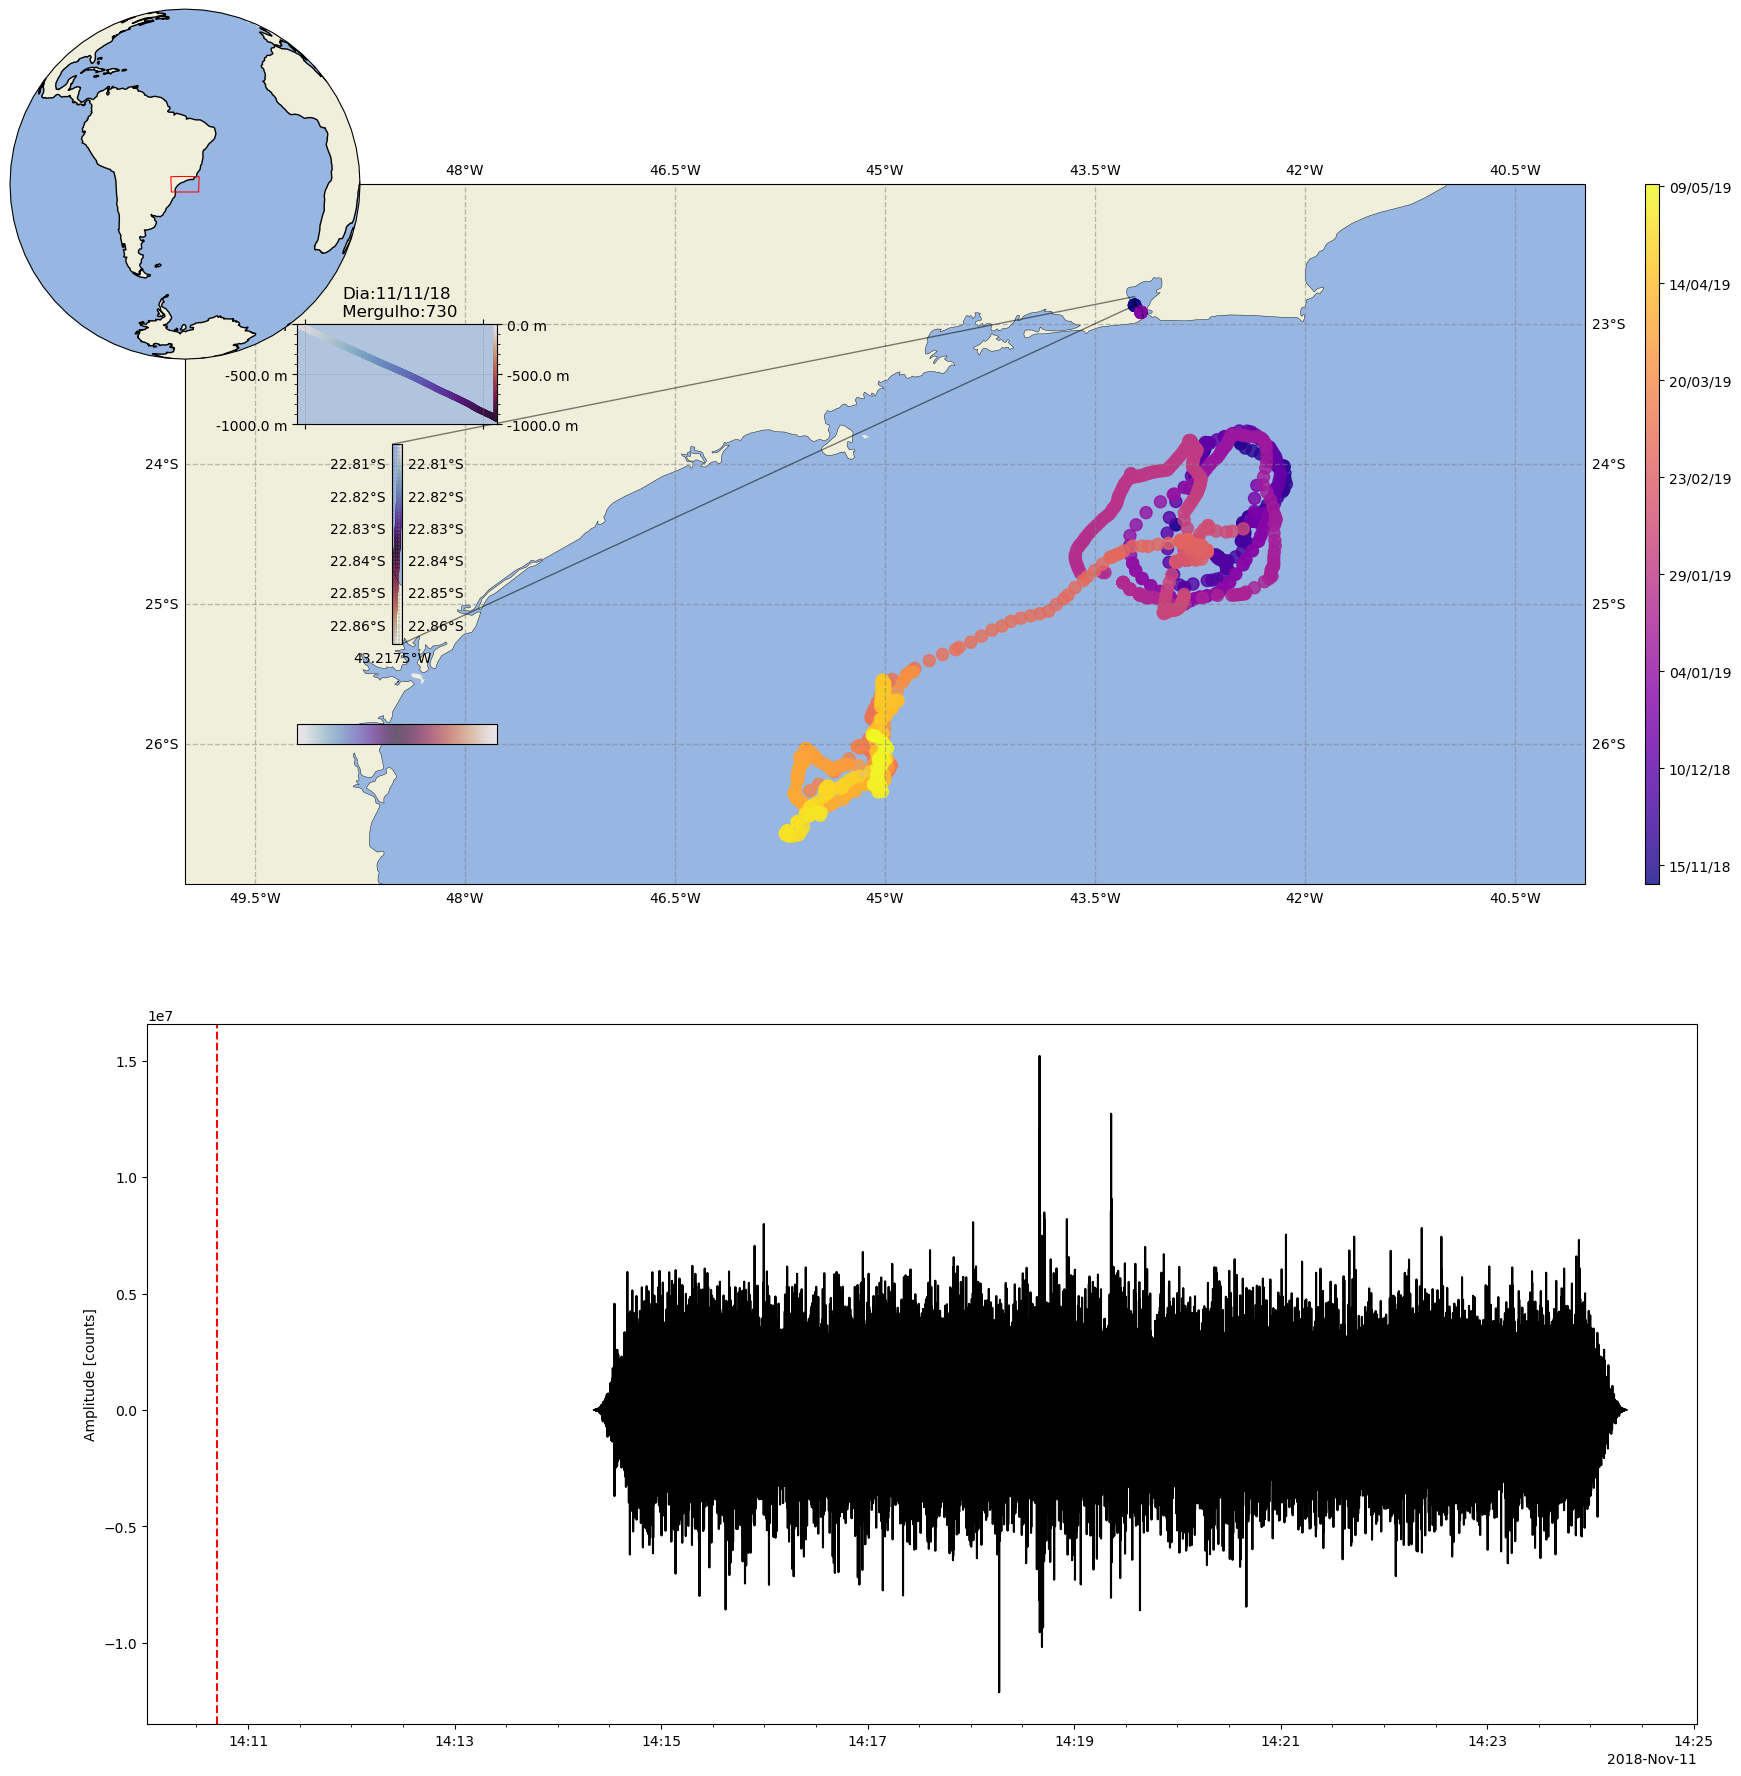

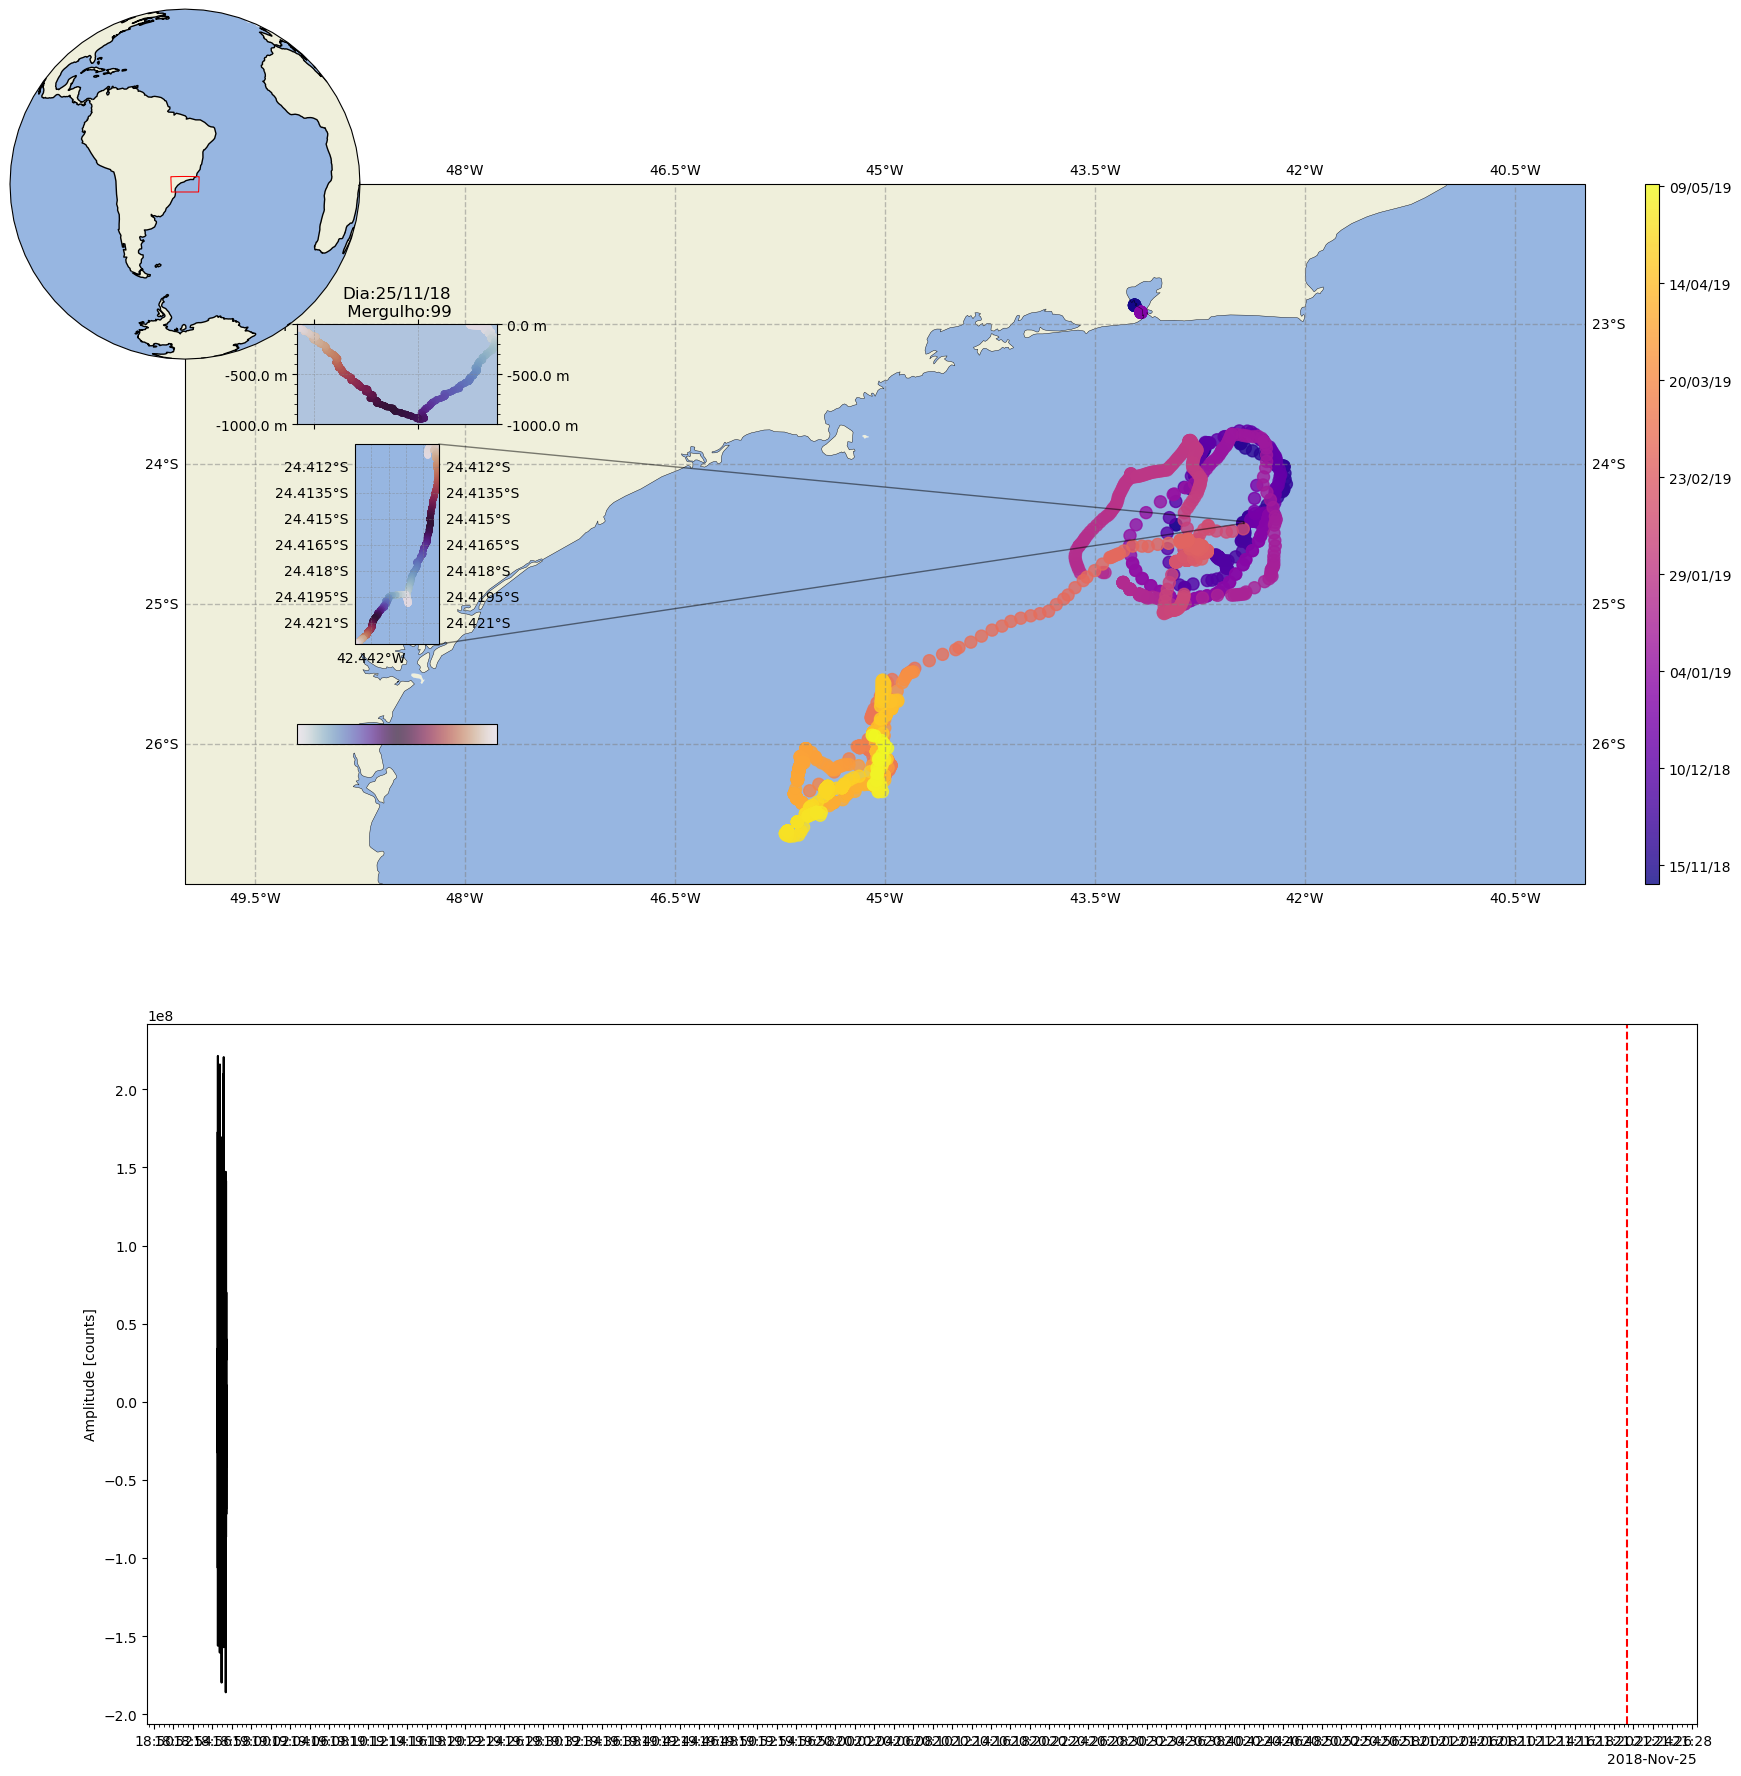

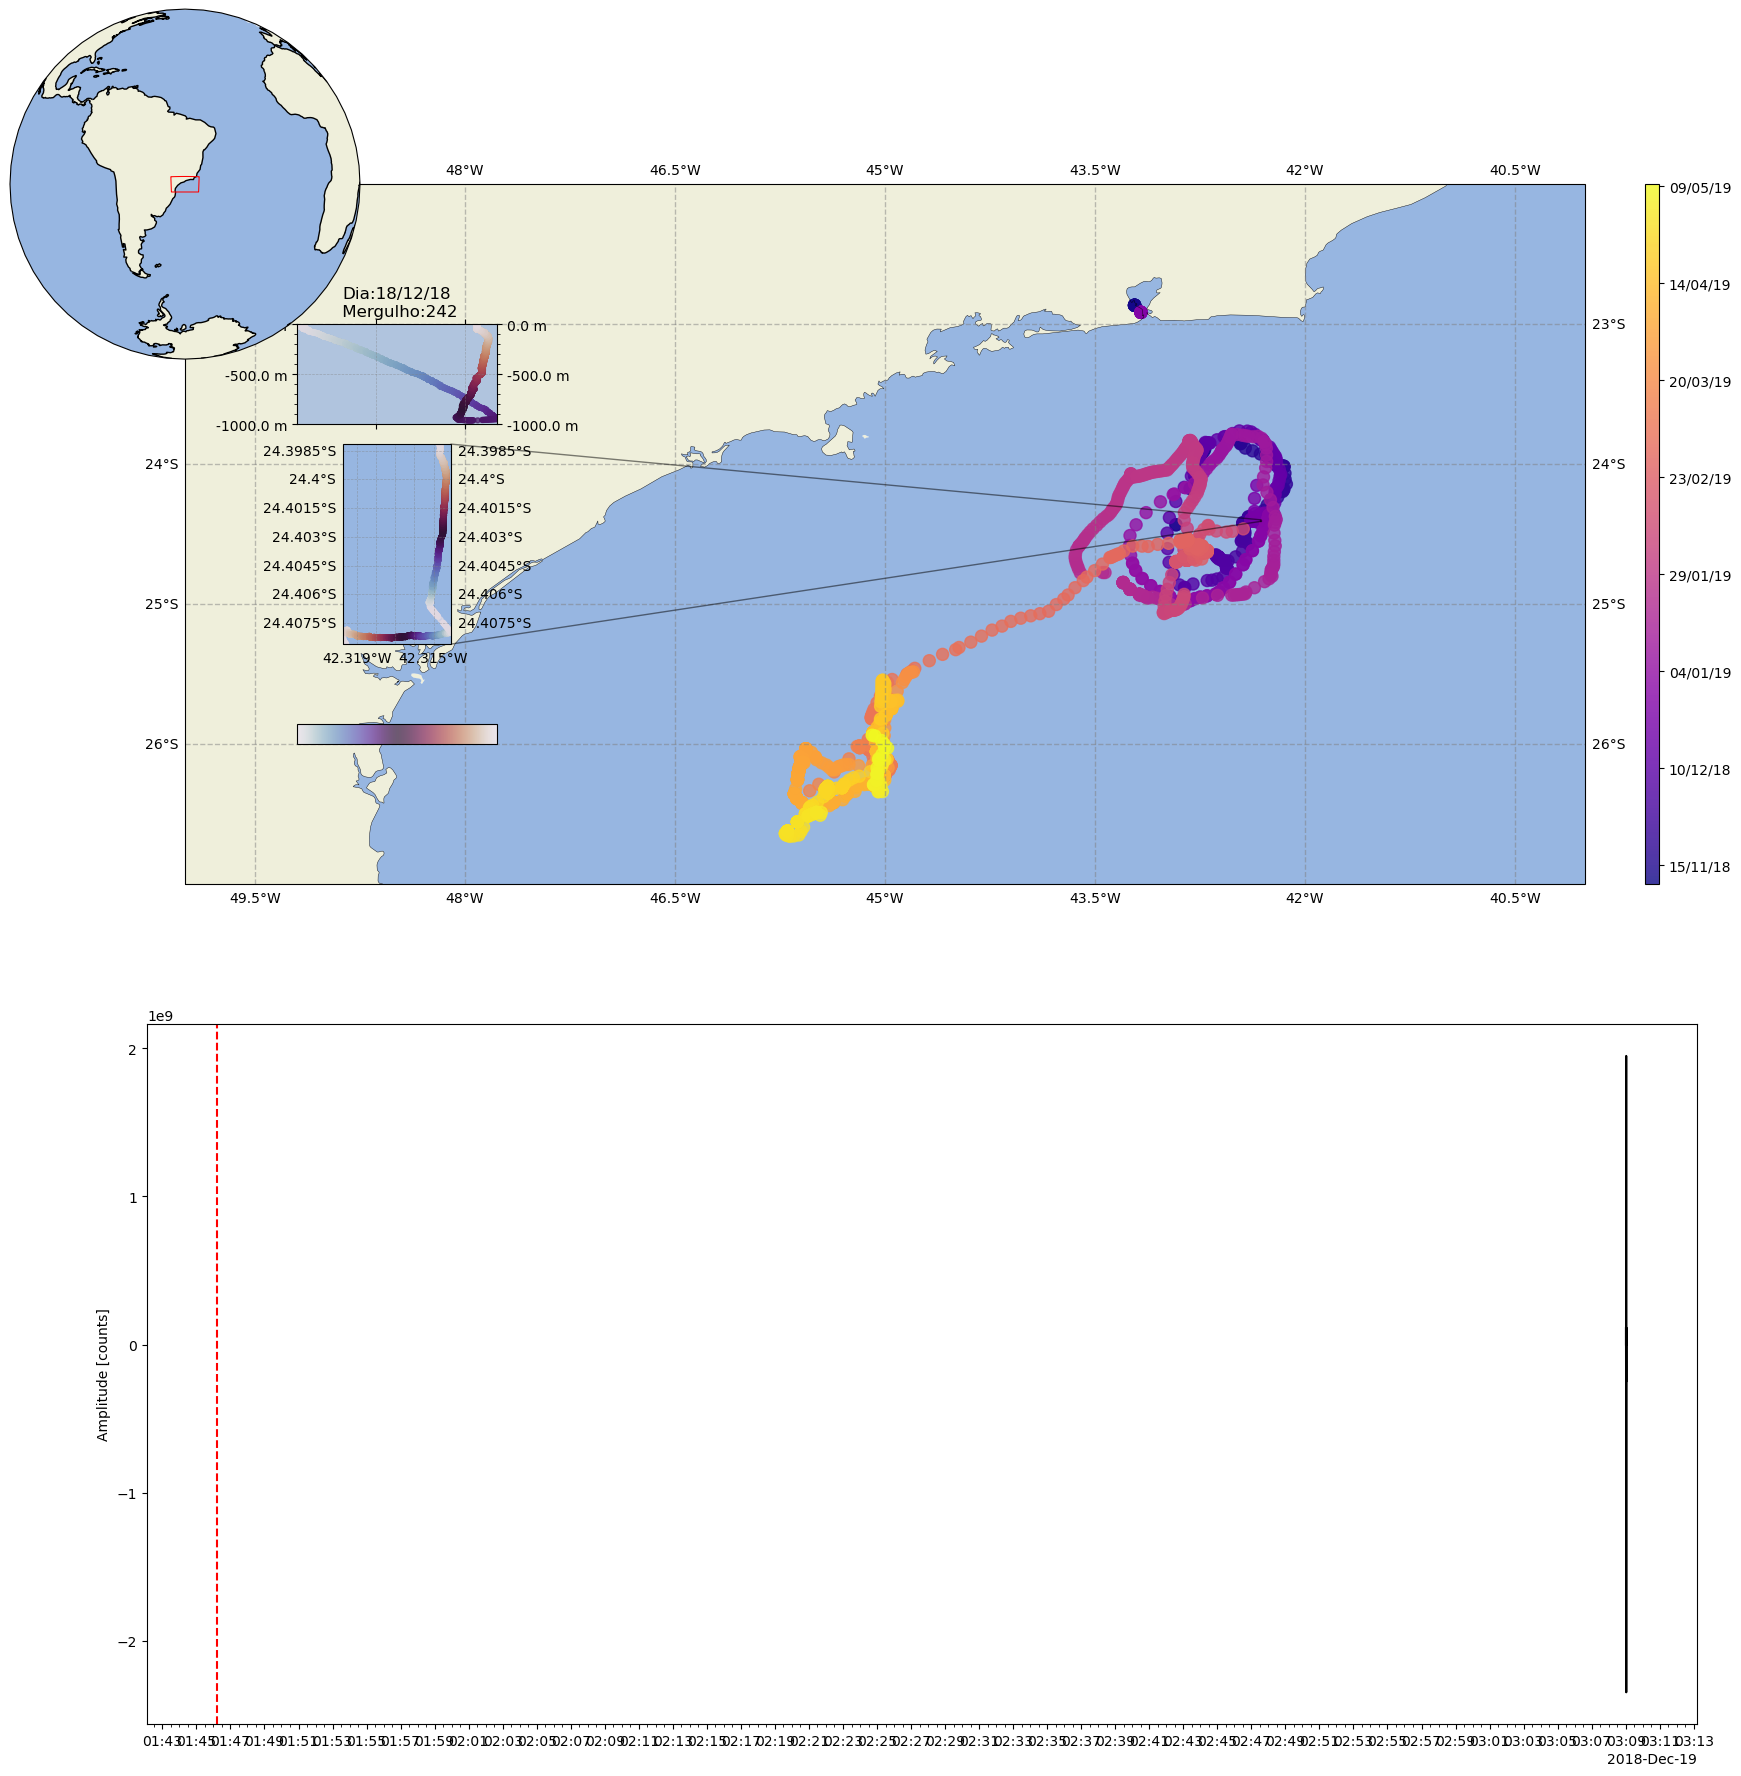

In [245]:
for ev in events:
    try:
        ev_time = ev.origins[0].time
        ev_lat = ev.origins[0].latitude
        ev_long = ev.origins[0].longitude
        ev_depth =  ev.origins[0].depth/1000
              
        file_event_nc_info = df_glider_log_final[(df_glider_log_final.time_start.dt.to_pydatetime() <= ev_time) & (df_glider_log_final.time_end.dt.to_pydatetime() >= ev_time)]['file_location'].values[0]
        lat_event_nc_info = df_glider_log_final[(df_glider_log_final.time_start.dt.to_pydatetime() <= ev_time) & (df_glider_log_final.time_end.dt.to_pydatetime() >= ev_time)]['lat'].values[0]
        lon_event_nc_info = df_glider_log_final[(df_glider_log_final.time_start.dt.to_pydatetime() <= ev_time) & (df_glider_log_final.time_end.dt.to_pydatetime() >= ev_time)]['lon'].values[0]
          
        #Calculating distance, azimuth and backazimuth
        dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_event_nc_info,lon_event_nc_info)
        gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
  
        #Calculating ray parameter
        model = TauPyModel(model='iasp91')
        arrivals = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P"])
        arr = arrivals[0]

        #Reference time
        event = ev_time+arr.time
        print(event)

        #########################################################################################################################################################
        #STREAM 
        
        # Calcule a diferença absoluta entre as datas e o valor de referência
        dataframe_mseed_final['diff'] = np.abs(dataframe_mseed_final['starttime'].dt.to_pydatetime() - event.datetime)

        # Obtenha o índice da linha com a menor diferença
        index_next = dataframe_mseed_final['diff'].idxmin()

        # Obtenha a data mais próxima
        file_event_mseed = dataframe_mseed_final.loc[index_next, 'filename']
        
        file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/'+file_event_mseed+'*'))[0]
        
        stream_mseed = read(file_mseed_ev)[0]
        print(stream_mseed)
                
        #########################################################################################################################################################
        #NetCDF 
        
        dic_event = gt.load.seaglider_basestation_netCDFs(file_event_nc_info, names,verbose=False)

        #########################################################################################################################################################
        #Figure 
        
        # set up the plot and create a GeoAxes:
        proj = ccrs.PlateCarree()
        
        fig, (ax, ax1) = plt.subplots(2, 1,figsize=(20,20))
        ax = plt.subplot(2, 1, 1, projection=proj)

        # ----------------------------------------------------------------------------------------------------------
        # Limit the extent of the map to a small longitude/latitude range.
        latmin=-27
        latmax=-22
        lonmin=-50
        lonmax=-40

        ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

        # ----------------------------------------------------------------------------------------------------------
        # Ploting lat/lon values

        h = ax.scatter(df_glider_log_final['lon'].values,df_glider_log_final['lat'].values,c=df_glider_log_final['time_coverage_start'],marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
        # ----------------------------------------------------------------------------------------------------------
        # Adding background map 
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
        ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
        ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

        # ----------------------------------------------------------------------------------------------------------
        # Adding colorbar
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

        fig.add_axes(ax_cb)
        cb = plt.colorbar(h, cax=ax_cb)
        cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

        #####################################################
        # Adding inset axes RIGHT
        #####################################################

        axins = plt.axes([0.2, 0.65, 0.1, 0.1],projection=proj)

        dz = depth_to_plot
        norm = colors.Normalize(dz.min(), dz.max())
        colors_map = cm.plasma(norm(dz))
        j = axins.scatter(dic_event['sg_data_point']['longitude'], dic_event['sg_data_point']['latitude'], c=[i*-1 for i in dic_event['sg_data_point']['depth']],marker='.',alpha=0.7,cmap='twilight',s=50,transform=proj)

        axins.add_feature(cfeature.LAND)
        axins.add_feature(cfeature.OCEAN)
        axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
        axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
        # ----------------------------------------------------------------------------------------------------------
        # Adding grid 
        axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

        # subregion of the original image
        x1 = dic_event['sg_data_point'].attrs['geospatial_lon_min']
        x2 = dic_event['sg_data_point'].attrs['geospatial_lon_max']
        y1 = dic_event['sg_data_point'].attrs['geospatial_lat_min']
        y2 = dic_event['sg_data_point'].attrs['geospatial_lat_max']
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

        # ----------------------------------------------------------------------------------------------------------
        # Adding ZOOM
        ax.indicate_inset_zoom(axins, edgecolor="black")

        # ----------------------------------------------------------------------------------------------------------
        ax_histx = plt.axes([0.2, 0.76, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
        ax_histx.scatter(dic_event['sg_data_point']['longitude'], [i*-1 for i in dic_event['sg_data_point']['depth']], c=[mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dic_event['sg_data_point']['time']],marker='.',alpha=0.7,cmap='twilight',s=50)
        ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax_histx.set_title("Dia:"+mdates.num2date([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dic_event['sg_data_point']['time']][0]).strftime('%d/%m/%y')+"\n Mergulho:"+str(int(dic_event['sg_data_point'].attrs['number_of_dives'])))
        ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
        ax_histx.set_ylim(-1000,0)
        ax_histx.yaxis.set_major_formatter('{x} m')
        ax_histx.yaxis.set_major_locator(MultipleLocator(500))
        ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

        # ----------------------------------------------------------------------------------------------------------
        # Adding colorbar
        cax = plt.axes([0.2, 0.6, 0.1, 0.01])
        date_colorbar = np.linspace(min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dic_event['sg_data_point']['time']]), max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dic_event['sg_data_point']['time']]), 4, endpoint=True)
        cb = plt.colorbar(j, cax=cax,orientation='horizontal',ticks=date_colorbar)
        cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        # ----------------------------------------------------------------------------------------------------------
        # Adding global location map
        # inset location relative to main plot (ax) in normalized units
        inset_x = 0
        inset_y = 1
        inset_size = 0.5

        # Adding Geoaxes
        ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
        ax2.set_global()

        # Adding background map 
        ax2.add_feature(cfeature.LAND)
        ax2.add_feature(cfeature.OCEAN)
        ax2.add_feature(cfeature.COASTLINE)

        # Adding inset geoaxes position
        ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                inset_y - inset_size / 2,
                                inset_size,
                                inset_size])
        ax2.set_axes_locator(ip)


        # Adding red rectangle position
        nvert = 100
        lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                     np.linspace(lonmin, lonmax, nvert),
                     np.linspace(lonmax, lonmax, nvert)].tolist()
        lats = np.r_[np.linspace(latmin, latmax, nvert),
                     np.linspace(latmax, latmax, nvert),
                     np.linspace(latmax, latmin, nvert)].tolist()

        ring = LinearRing(list(zip(lons, lats)))
        ax2.add_geometries([ring], ccrs.PlateCarree(),
                           facecolor='none', edgecolor='red', linewidth=0.75)
        
        
        # ----------------------------------------------------------------------------------------------------------
        # Adding stream plot
       
        ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
        ax1.plot(stream_mseed.times('matplotlib'),stream_mseed.data,'-k')        
        ax1.set_ylabel('Amplitude [counts]')
        locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
        formatter = mdates.ConciseDateFormatter(locator)
        ax1.xaxis.set_major_locator(locator)
        ax1.xaxis.set_major_formatter(formatter)
        mins2 = SecondLocator(interval=120)
        mins1 = SecondLocator(interval=30)
        ax1.xaxis.set_major_locator(mins2)
        ax1.xaxis.set_minor_locator(mins1)

    except:
        pass
    